In [1]:
!pip install trimesh

In [2]:
import trimesh
import numpy as np

## Denavit Hartenberg Parameters

Compute the transform from DH parameters to the transform matrix.

In [3]:
def dh_param_transform(d, theta, r, alpha):
    """
    Compute the 4x4 transformation matrix associated with the Denavit hartenberg parameters
    """
    T_d_theta = np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta),  np.cos(theta), 0, 0],
        [            0,              0, 1, d],
        [            0,              0, 0, 1],
    ])
    T_r_alpha = np.array([
        [1,             0,              0, r],
        [0, np.cos(alpha), -np.sin(alpha), 0],
        [0, np.sin(alpha),  np.cos(alpha), 0],
        [0,             0,              0, 1],
    ])
    
    return T_d_theta @ T_r_alpha

#### Define Denavit Hartenberg Parameters for the arm

In [4]:
# # Got them from here: https://www.thingiverse.com/thing:2747086
URL_FORMAT = "https://github.com/wecacuee/ECE417-F24-Mobile-Robots/blob/master/docs/notebooks/11-05-fwd-kinematics/meshes/reset/{part_name}_reset.stl?raw=true"
# URL_FORMAT = "meshes/reset/{part_name}_reset.stl"
base1_reset2 = trimesh.load_remote(URL_FORMAT.format(part_name="base1"))
base2_reset2 = trimesh.load_remote(URL_FORMAT.format(part_name="base2"))
shoulder_reset2 = trimesh.load_remote(URL_FORMAT.format(part_name="shoulder"))
elbow_reset2 = trimesh.load_remote(URL_FORMAT.format(part_name="elbow"))
gripper1_reset2 = trimesh.load_remote(URL_FORMAT.format(part_name="gripper1"))
gripper2_reset2 = trimesh.load_remote(URL_FORMAT.format(part_name="gripper2"))
links = [base1_reset2, base2_reset2, shoulder_reset2, 
         elbow_reset2, gripper1_reset2, gripper2_reset2]
xyz = trimesh.creation.axis(axis_length=200, axis_radius=1) # X = red, Y = green, Z = blue
trimesh.scene.Scene(links).show()

In [5]:
import numpy as np
dh_param_table_scaled = np.array([
    [257, +0, -10, np.pi/2],
    [0, np.pi/2, 200, 0],
    [0, -0, 190, 0],
    [3, np.pi/2, 0, np.pi/2],
    [0, 0, 0, 0],
])

In [6]:
def forward_kinematics(thetas, dh_param_table_scaled):
    """
    Compute the transformation matrices for all the links
    """
    # T_0_from_i is a list that contains 4x4 Transformation matrices
    # for example T_0_from_3 converts from 3rd coordinate frame to the zeroth
    T_0_from_i = [np.eye(4)]*(len(dh_param_table_scaled)+1)

    # T_0_from_0 is identity
    T_0_from_i[0] = np.eye(4)
    
    # Use DH Parameters and additional thetas to compute each transform
    for i in range(1, 1+dh_param_table_scaled.shape[0]):
        # Add additional theta for motor rotations
        d, theta, r, alpha = dh_param_table_scaled[i-1]
        theta += thetas[i-1]

        # Compute transformation matrix from i to i-1
        # T_im1_from_i is short for T_(i minus 1) from i
        T_im1_from_i = dh_param_transform(d, theta, r, alpha)

        # Use the previous transformation to get the next one.
        T_0_from_i[i] = T_0_from_i[i-1] @ T_im1_from_i

    # Return the full list
    return T_0_from_i

Now we can use forward kinematics to move the arm

In [7]:
# Change these motor angles to move the robotic arm
motor_angles = [0, 0., 0., 0., 0.]
import ipywidgets as widgets
sliders = [widgets.FloatSlider(min=-180, value=0, max=180) for _ in range(5)]
display(*sliders)


FloatSlider(value=0.0, max=180.0, min=-180.0)

FloatSlider(value=0.0, max=180.0, min=-180.0)

FloatSlider(value=0.0, max=180.0, min=-180.0)

FloatSlider(value=0.0, max=180.0, min=-180.0)

FloatSlider(value=0.0, max=180.0, min=-180.0)

In [8]:
motor_angles = np.deg2rad([ma.value for ma in sliders])
motor_angles

array([0., 0., 0., 0., 0.])

In [9]:
T_0_from_i = forward_kinematics(motor_angles, 
                                dh_param_table_scaled)

transformed_parts = []
xyzs = []
for i in range(len(links)):
    # Apply transform to each mesh part
    transformed_parti = links[i].copy().apply_transform(T_0_from_i[i])
    transformed_parts.append(transformed_parti)

    # Also create transformed coordinate axes for visualization
    xyzs.append(
        trimesh.creation.axis(transform=T_0_from_i[i],
                                  axis_length=200, axis_radius=1)
    )

scene = trimesh.scene.Scene(transformed_parts+xyzs)
scene.show()

# Inverse kinematics



In [10]:
def cross_prod_mat(k):
    return np.array([[0, -k[2], k[1]],
                     [k[2], 0, -k[0]],
                     [-k[1], k[0], 0]])


def rodrigues(k, theta):
    k = np.asarray(k)
    k /= np.linalg.norm(k)
    K = cross_prod_mat(k)
    return np.eye(3) + np.sin(theta) * K + (1-np.cos(theta)) * K @ K


def transform_inverse(T):
    R = T[:3, :3]
    t = T[:3, 3]
    Tinv = np.eye(4)
    Tinv[:3, :3] = R.T
    Tinv[:3, 3] = -R.T @ t
    return Tinv

def dh_param_transform_deriv_wrt_theta(d, theta, r, alpha):
    """
    Compute the 4x4 derivative of the transformation matrix associated 
    with the Denavit hartenberg parameters. 
    
    We are assuming theta is variable and the derivative is with respect to
    theta.
    """
    
    K = cross_prod_mat([0., 0., 1.])
    T_K = np.zeros((4,4))
    T_K[:3, :3] = K

    T_R = np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta),  np.cos(theta), 0, 0],
        [            0,              0, 1, 0],
        [            0,              0, 0, 0],
    ])
    # ∂ R(θ)/∂θ = [k]ₓ R(θ)
    # where k is the axis of rotation and [k]ₓ is the cross product matrix
    Jac_T_d_theta_wrt_theta = T_K @ T_R
    T_r_alpha = np.array([
        [1,             0,              0, r],
        [0, np.cos(alpha), -np.sin(alpha), 0],
        [0, np.sin(alpha),  np.cos(alpha), 0],
        [0,             0,              0, 1],
    ])
    
    return Jac_T_d_theta_wrt_theta @ T_r_alpha

In [11]:
from functools import reduce
theta_0 = np.array([0., -np.pi/3, -np.pi/3, 0., 0.])
dh_param_table_scaled_updated = [(d, theta+angle, r, alpha)
        for angle, (d, theta, r, alpha) in zip(theta_0, dh_param_table_scaled)]
Jacobian_forward_kinematics = np.zeros((12, 5))
T_im1_from_i_list = [dh_param_transform(d, theta, r, alpha)
    for d, theta, r, alpha in dh_param_table_scaled_updated]
T_im1_from_i_deriv_wrt_theta_list = [
    dh_param_transform_deriv_wrt_theta(d, theta, r, alpha)
    for d, theta, r, alpha in dh_param_table_scaled_updated]

In [12]:
Jacobian_forward_kinematics[:, 0] = (
    T_im1_from_i_deriv_wrt_theta_list[0] 
    @ T_im1_from_i_list[1]
    @ T_im1_from_i_list[2]
    @ T_im1_from_i_list[3]
    @ T_im1_from_i_list[4])[:3, :].flatten()

Jacobian_forward_kinematics[:, 1] = (
    T_im1_from_i_list[0]
    @ T_im1_from_i_deriv_wrt_theta_list[1] 
    @ T_im1_from_i_list[2]
    @ T_im1_from_i_list[3]
    @ T_im1_from_i_list[4])[:3, :].flatten()


Jacobian_forward_kinematics[:, 2] = (
    T_im1_from_i_list[0]
    @ T_im1_from_i_list[1]
    @ T_im1_from_i_deriv_wrt_theta_list[2] 
    @ T_im1_from_i_list[3]
    @ T_im1_from_i_list[4])[:3, :].flatten()

Jacobian_forward_kinematics[:, 3] = (
    T_im1_from_i_list[0]
    @ T_im1_from_i_list[1]
    @ T_im1_from_i_list[2]
    @ T_im1_from_i_deriv_wrt_theta_list[3] 
    @ T_im1_from_i_list[4])[:3, :].flatten()

Jacobian_forward_kinematics[:, 4] = (
    T_im1_from_i_list[0]
    @ T_im1_from_i_list[1]
    @ T_im1_from_i_list[2]
    @ T_im1_from_i_list[3]
    @ T_im1_from_i_deriv_wrt_theta_list[4])[:3, :].flatten()

In [13]:
T_0_from_4_desired = np.eye(4)
T_0_from_4_desired[:3, 3] = [300, 300, 0]
T_0_from_4_actual = (T_im1_from_i_list[0] 
    @ T_im1_from_i_list[1] 
    @ T_im1_from_i_list[2] 
    @ T_im1_from_i_list[3] 
    @ T_im1_from_i_list[4])

In [14]:
def visualize_arm(motor_angles):
    T_0_from_i = forward_kinematics(motor_angles, 
                                    dh_param_table_scaled)
    
    transformed_parts = []
    xyzs = []
    for i in range(len(links)):
        # Apply transform to each mesh part
        transformed_parti = links[i].copy().apply_transform(T_0_from_i[i])
        transformed_parts.append(transformed_parti)
    
        # Also create transformed coordinate axes for visualization
        xyzs.append(
            trimesh.creation.axis(transform=T_0_from_i[i],
                                      axis_length=200, axis_radius=1)
        )
    scene = trimesh.scene.Scene(transformed_parts+xyzs)
    return scene.show()
    
visualize_arm(theta_0)

In [15]:
# Intialize a value

theta_1 = theta_0 - np.linalg.lstsq(
     Jacobian_forward_kinematics, 
     (T_0_from_4_actual[:3, :] - T_0_from_4_desired[:3, :]).flatten())[0]
theta_1 % (2*np.pi)

array([0.        , 6.15949977, 4.46177326, 0.77421449, 0.46175601])

In [16]:
visualize_arm(theta_1)

In [17]:
def compute_forward_and_jacobian(motor_angles, dh_param_table_scaled):
    dh_param_table_scaled_updated = [(d, theta+angle, r, alpha)
        for angle, (d, theta, r, alpha) in zip(motor_angles, dh_param_table_scaled)]
    Jacobian_forward_kinematics = np.zeros((12, 5))
    T_im1_from_i_list = [dh_param_transform(d, theta, r, alpha)
        for d, theta, r, alpha in dh_param_table_scaled_updated]
    T_im1_from_i_deriv_wrt_theta_list = [
        dh_param_transform_deriv_wrt_theta(d, theta, r, alpha)
        for d, theta, r, alpha in dh_param_table_scaled_updated]
    T_0_from_4_actual = (T_im1_from_i_list[0] 
        @ T_im1_from_i_list[1] 
        @ T_im1_from_i_list[2] 
        @ T_im1_from_i_list[3] 
        @ T_im1_from_i_list[4])
    Jacobian_forward_kinematics[:, 0] = (
        T_im1_from_i_deriv_wrt_theta_list[0] 
        @ T_im1_from_i_list[1]
        @ T_im1_from_i_list[2]
        @ T_im1_from_i_list[3]
        @ T_im1_from_i_list[4])[:3, :].flatten()
    
    Jacobian_forward_kinematics[:, 1] = (
        T_im1_from_i_list[0]
        @ T_im1_from_i_deriv_wrt_theta_list[1] 
        @ T_im1_from_i_list[2]
        @ T_im1_from_i_list[3]
        @ T_im1_from_i_list[4])[:3, :].flatten()
    
    Jacobian_forward_kinematics[:, 2] = (
        T_im1_from_i_list[0]
        @ T_im1_from_i_list[1]
        @ T_im1_from_i_deriv_wrt_theta_list[2]  
        @ T_im1_from_i_list[3]
        @ T_im1_from_i_list[4])[:3, :].flatten()
    Jacobian_forward_kinematics[:, 3] = (
        T_im1_from_i_list[0]
        @ T_im1_from_i_list[1]
        @ T_im1_from_i_list[2]
        @ T_im1_from_i_deriv_wrt_theta_list[3] 
        @ T_im1_from_i_list[4])[:3, :].flatten()
    
    Jacobian_forward_kinematics[:, 4] = (
        T_im1_from_i_list[0]
        @ T_im1_from_i_list[1]
        @ T_im1_from_i_list[2]
        @ T_im1_from_i_list[3]
        @ T_im1_from_i_deriv_wrt_theta_list[4])[:3, :].flatten()
    return T_0_from_4_actual, Jacobian_forward_kinematics

In [18]:
theta_0 = np.array([0., -np.pi/3, -np.pi/3, -np.pi/2., 0.])
T_0_from_4_desired = np.eye(4)
T_0_from_4_desired[:3, 3] = [300, 0, 0]
T_0_from_4_actual, Jacobian_forward_kinematics = compute_forward_and_jacobian(
    theta_0, dh_param_table_scaled)
print("Error 0: %f" % np.sum((T_0_from_4_actual[:3, :] - T_0_from_4_desired[:3, :])**2))
theta_1 = theta_0 - np.linalg.lstsq(
     Jacobian_forward_kinematics, 
     (T_0_from_4_actual[:3, :] - T_0_from_4_desired[:3, :]).flatten())[0]
theta_1 % (2*np.pi)
T_0_from_4_actual, Jacobian_forward_kinematics = compute_forward_and_jacobian(
    theta_1, dh_param_table_scaled)
print("Error 1: %f" % np.sum((T_0_from_4_actual[:3, :] - T_0_from_4_desired[:3, :])**2))
print(theta_1)
visualize_arm(theta_1)

Error 0: 69431.057365
Error 1: 10716.089846
[ 0.00915328 -1.66463957 -1.37208784 -0.62846402  0.00792697]


Iter: 0; Error: 270.365240
Iter: 1; Error: 207.388521
Iter: 2; Error: 200.035170
Iter: 3; Error: 86.747937
Iter: 4; Error: 11.163229
Breaking at iter 5; error 0.471214; pos: array([159.72158092,   0.26376741,  50.0663377 ])
[ 0.02043518 -1.66704019 -1.62981129  0.34849148 -1.56534918]


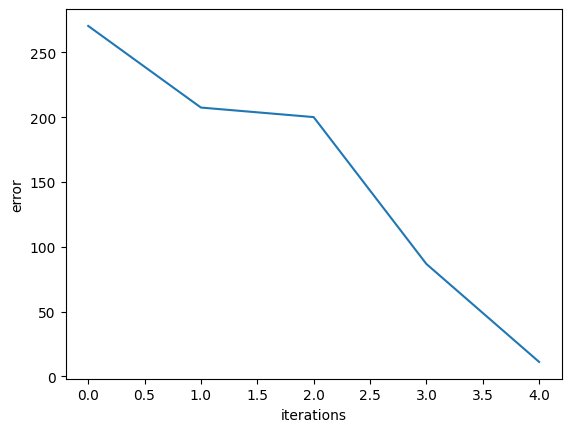

In [20]:
theta_0 = np.array([0., -np.pi/3, -np.pi/3, -np.pi/2, 0.])
T_0_from_4_desired = np.eye(4)
T_0_from_4_desired[:3, :3] = rodrigues([1., 1., 0.], np.pi-np.pi/12)
T_0_from_4_desired[:3, 3] = [160, 0, 50]
theta = theta_0
errors = []
for count in range(100):
    T_0_from_4_actual, Jacobian_forward_kinematics = compute_forward_and_jacobian(
        theta, dh_param_table_scaled)
    error = np.sqrt(np.sum((T_0_from_4_actual[:3, :] - T_0_from_4_desired[:3, :])**2))
    if error < 1:
        print("Breaking at iter %d; error %f; pos: %r" % (count , error, T_0_from_4_actual[:3, 3]))
        break
    else:
        print("Iter: %d; Error: %f" % (count, error))
        errors.append(error)
    theta = theta - np.linalg.lstsq(
         Jacobian_forward_kinematics, 
         (T_0_from_4_actual[:3, :] - T_0_from_4_desired[:3, :]).flatten())[0]
    theta = (theta+np.pi) % (2*np.pi) - np.pi
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(errors); ax.set_xlabel('iterations'); ax.set_ylabel('error')
print(theta)
visualize_arm(theta)